# Text processing

The aims of the lab are to:
*   Introduce you to colab, verify that you're setup with the correct python packages
*   Learn to perform text processing: tokenization, normalization, and segmentation of text 
*   Calculate basic collection statistics of a corpus of text
*   Introduce the spaCy python library for text processing 
*   Learn the details of how a *dictionary* is implemented
*   Practice creating a sparse one-hot encoding 
*   Implement Jaccard similarity


## Submission

**Labs are not graded**, but we are collecting your labwork. 

* An ungraded [Moodle quiz](https://moodle.gla.ac.uk/mod/quiz/view.php?id=1409115) allows you to assess the correctness of your work on key parts of the lab.  This allows you to assess your own progress. 

* Please submit the .ipynb of your file following the instructions on the [submission page](https://moodle.gla.ac.uk/mod/assign/view.php?id=1409110).




## Colab Introduction


Colab is a cloud-based Jupyter Notebook.  It is used internally by engineers and researchers at Google and companies worldwide to prototype and share data science and ML results in an easy-to-use way. 

It supports:

1. Text Cells with [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) formatting
2. Code Cells
3. Notebook stores code, output, and execution order
4. Tab and Tab + Tab Autocomplete
5. IPython Help Features
6. IPython Magics (`%%`)

### Additional Features

- collaborative editing
- history 
- comments
- executed code history
- Shift+click multiple cell selection
- searchable code snipetts + table of contents
- scratchpad (⌘/Ctrl + Alt + N)

### Keyboard Shortcuts
| Command | Action |
| ---- | ----: |
|⌘/Ctrl+Enter | Run Selected Cell |
|Shift+Enter| Run Cell and Select Next |
|Alt+Enter| Run cell and insert new cell|
|⌘/Ctrl+M I | Interrupt Execution |

- You can open the command Palette to see all shortcuts by going to Tools --> Command palette.

### Summary of tips
- Use TAB to autocomplete an expression. 
- You can also execute the code with a ? to get the doc strings
- In Jupyter / Colab you can execute shell commands using `!`, example: "!ls" to list the current files.


*Note:* Occassionally colab may hang or crash (due to cloud flakiness or bad code).  You can control the execution using the Runtime menu to reboot and start fresh.  To resume where you left off you can click "Run before" and it will run all cells before the one currently selected.


*Note:* You can use Colab with a cloud VM or connect to a 'local' Jupyter instance.

## Setup 

#### Your task:####
Just run the cells below, and verify that the output is as expected. If anything looks wrong, weird, or crashes, contact the course staff. We don't want library issues to get in the way of the real work! 

In [69]:
import sys
print(sys.version)

# Version checks
import importlib
def version_check(libname, min_version):
    m = importlib.import_module(libname)
    print ("%s version %s is" % (libname, m.__version__))
    print ("OK" if m.__version__ >= min_version 
           else "out-of-date. Please upgrade!")
    
version_check("numpy", "1.14")
version_check("matplotlib", "1.6")
version_check("pandas", "0.22")

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
numpy version 1.17.5 is
OK
matplotlib version 3.1.2 is
OK
pandas version 0.25.3 is
OK


## Getting help with Pandas

Let's get some help with the Pandas library we'll be using later.  The DataFrame is the main data collection representation in Pandas, so it's important to learn what's possible to do with it. 

### An aside on Pandas
Pandas is a widely used Python-standard library for dealing with data. It processes data in a DataFrame, which you can think of as a relational table with columns. Our focus in TaD is not on Pandas or relational data. However, Pandas provides a convenient framework for processing and manipulating all kinds of data (including text). We will use it to store and operate on the Reddit data.


In [0]:
import pandas as pd

# Show the method signature and documentation
pd.DataFrame?



### Executing local commands
We can look at the local VM environment properties available in CoLab VM (or local environment).  

#### Your task : 
In the code cell below, create shell commands (one per line) to Inspect the linux version (uname), current directory (pwd), the amount of space (df), and amount of disk (vmstat -s). The output will be printed in the notebook.

In [71]:
# YOUR CODE HERE
!uname
!pwd
!df
!vmstat -s

Linux
/content
Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        113008892 29585732  77639608  28% /
tmpfs              65536        0     65536   0% /dev
tmpfs            6667592        0   6667592   0% /sys/fs/cgroup
tmpfs            6667592        8   6667584   1% /var/colab
/dev/sda1      119512108 31207500  88288224  27% /etc/hosts
shm              6291456        4   6291452   1% /dev/shm
tmpfs            6667592        0   6667592   0% /proc/acpi
tmpfs            6667592        0   6667592   0% /proc/scsi
tmpfs            6667592        0   6667592   0% /sys/firmware
     13335188 K total memory
      4103704 K used memory
      2360844 K active memory
      4101508 K inactive memory
      6597372 K free memory
        78972 K buffer memory
      2555140 K swap cache
            0 K total swap
            0 K used swap
            0 K free swap
        23062 non-nice user cpu ticks
            0 nice user cpu ticks
         3203 system cpu ticks
       77

# Load and process Reddit data
This lab will be performed on a 'real-world' collection of Reddit posts.  

The main unit of processing is a reddit *thread*; it represents a discussion topic with a unique URL. The thread contains metadata as well as the *posts* within it. A *post* is a single user entry in a thread. A post has the *body*, its *author*, it's position in the thread, as well as other metadata. 

**Thread fields**
*   URL - reddit URL of the thread
*   title - title of the thread, as written by the first poster
*   is_self_post - True if the first post in the thread is a self-post (text addressed to the reddit community as opposed to an external link)
*   subreddit - the subreddit of the thread
*   posts - a list of all posts in the thread

**Post fields**
*   id - post ID, reddit ID of the current post
*   body - the text of the post
*   in_reply_to - parent ID, reddit ID of the parent post, or the post that the current post is in reply to
*   post_depth - the number of replies the current post is from the initial post
*   is_first_post - True if the current post is the initial post


Download the Reddit dataset. It's approximately 80 megabytes. It's recommended that this is done in a Colab notebook for this reason. 

Note: We are using cloud utilities for download that are built into colab. Jupyter does not have these.  A commented out wget equivalent is included below as well. 

In [72]:
# The local location to store the reddit dataset.
local_file = "coarse_discourse_dump_reddit.json"

# The ! performs a shell command to download the reddit dataset from a Google cloud bucket. If you use this
# in jupyter directly, there is an equivalent command with wget below.
!gsutil cp gs://textasdata/coarse_discourse_dump_reddit.json $local_file
  
# The ! performs a shell command to download the reddit dataset using wget.
#!wget -O  $local_file https://storage.googleapis.com/textasdata/coarse_discourse_dump_reddit.json


Copying gs://textasdata/coarse_discourse_dump_reddit.json...
- [1 files][ 78.5 MiB/ 78.5 MiB]                                                
Operation completed over 1 objects/78.5 MiB.                                     


Note: We will be using the Pandas library as a way to manipulate the data easily.  Please refer to the [documentation](https://pandas.pydata.org/pandas-docs/stable/), or to this [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf) if you get stuck or need a refresher. 

Load the JSON data into DataFrame with each post as a row.

### Your task  

Extract values from the thread and posts to create a list of post objects.

Each post should have: 
- Thread subreddit
- Thread title
- Thread URL
- Post text
- Post author
- Post Body

If you look at the data frame there are other fields.  We may use them later in the course. 

In [0]:
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and cates a new data frame.
import pandas as pd
import json

# A temporary variable to store the list of posts.
posts_tmp = list()

with open(local_file) as jsonfile:
  for i, line in enumerate(jsonfile):
    threads = json.loads(line)
    # YOUR CODE HERE
    for post in threads['posts']:
      # Keep the thread title and subreddit with each post.
      posts_tmp.append((threads['subreddit'], threads['title'], threads['url'],
                        post['id'], post.get('author', ""), post.get('body', "")))

# Create the posts data frame.  
labels = ['subreddit', 'title', 'url', 'id', 'author', 'body']
post_frame = pd.DataFrame(posts_tmp, columns=labels)

In [0]:
#@title Show Code
# The reddit thread structure is nested with posts in a new content.
# This block reads the file as json and cates a new data frame.
import pandas as pd
import json

# A temporary variable to store the list of posts.
posts_tmp = list()

with open(local_file) as jsonfile:
  for i, line in enumerate(jsonfile):
    thread = json.loads(line)
    for post in thread['posts']:
      posts_tmp.append((thread['subreddit'], thread['title'], thread['url'],
                        post['id'], post.get('author', ""), post.get('body', "")))
# Create the posts data frame.  
labels = ['subreddit', 'title', 'url', 'id', 'author', 'body']
post_frame = pd.DataFrame(posts_tmp, columns=labels)

Let's learn more about the Reddit collection statistics. 

#### Your Task
Use `count()` on the `posts_frame` object to print a count distribution. 
- Note: `count()` gives the counts for each column in the data frame separately.

In [75]:
post_frame.count()

subreddit    110595
title        110595
url          110595
id           110595
author       110595
body         110595
dtype: int64

This should yield 110,595 for all the fields. 

#### Your task:
Select the subreddit column from the `post_frame` and store it in a variable, `subreddits`.

The result of selecting a column in a dataframe is a *Series* object.  

Use the [value_counts](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) feature to group and count the values for the `subreddits` series.

Using the value_counts on the `subreddits` variable do the following:
 - Print a statistical summary of the data using `.describe() `
 - Use `head()` to print out the top 5 subreddits with their counts

In [76]:
subreddits = post_frame['subreddit']
subreddits_vcs = subreddits.value_counts()
print(subreddits_vcs.describe())
print(subreddits_vcs.head())

count    2842.000000
mean       38.914497
std       130.537942
min         1.000000
25%         7.000000
50%        14.000000
75%        34.000000
max      5150.000000
Name: subreddit, dtype: float64
askreddit               5150
leagueoflegends         2438
buildapc                1442
electronic_cigarette    1060
pcmasterrace             933
Name: subreddit, dtype: int64


- What information is provided by the `describe()` function? 
- What does this statistical summary tell you about the frequency distrubution of threads in subreddits?  

#### Your task
Let's examine the question of how posts relate to threads. Each post has the thread it came from, defined by its URL.  Select the URLs and count the values.  Use what you learned in the previous task and print out the statistical summary using `describe`.  

In [77]:
post_frame['subodybodye_counts().head()# 

              2559
[deleted]      585
Thanks!         91
Thank you!      37
Yes             27
Name: body, dtype: int64

In [78]:
urls = post_frame['url']
urls_vsc = urls.value_counts()
print(subreddits_vcs.describe())
print(subreddits_vcs.head())
print(subreddits_vcs.tail())

count    2842.000000
mean       38.914497
std       130.537942
min         1.000000
25%         7.000000
50%        14.000000
75%        34.000000
max      5150.000000
Name: subreddit, dtype: float64
askreddit               5150
leagueoflegends         2438
buildapc                1442
electronic_cigarette    1060
pcmasterrace             933
Name: subreddit, dtype: int64
happypants           2
calgary              1
xna                  1
explainlikeimjive    1
playrustservers      1
Name: subreddit, dtype: int64


- Critically look at these statistics.  
- What is the shortest thread, longest thread?
- What about the average?

### Your task:

- Print a simple bar graph to visualize the top 20 most popular sub-reddits by number of posts. 

**Hint**:The Series object from `value_counts` has built-in functionality for getting the most frequent as well as plotting, look for "largest".  
**Workaround**: If you use your local jupyter, you will have to add an additional line for it work in colab, `%matplotlib inline`.

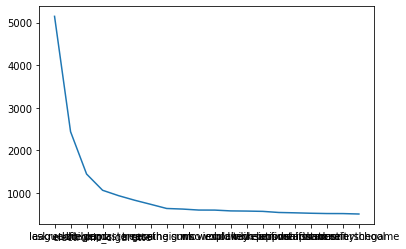

In [79]:
import matplotlib.pyplot as plt
plt.plot(subreddits_vcs.nlargest(20))

#### Your task 
- Create a bar plot of the top 10 authors of reddit posts.

*Note:* Not all posts have authors. As a first step you need to `replace` all empty values in the frame with a numpy nan value `np.nan`, after doing this pandas will filter them out automatically.

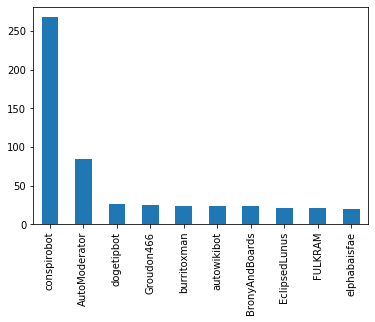

In [80]:
authors = post_frame['author']
authors_vcs = authors.value_counts()
authors_vcs.nlargest(11)[1:].plot.bar()

## Introduction to spaCy
[spaCy](https://spacy.io/) is an open-source software library for Natural Language Processing, written in Python and Cython. 

**Note:** SpaCy includes a variety of models. Below we use the english web small. In practice, better effectiveness can be obtained by using a larger model. See the full list of [models](https://spacy.io/usage/models).   

In [81]:
!python -m spacy download en

import spacy
import sys
print(sys.version)

# Version checks
import importlib
def version_check(libname, min_version):
    m = importlib.import_module(libname)
    print ("%s version %s is" % (libname, m.__version__))
    print ("OK" if m.__version__ >= min_version 
           else "out-of-date. Please upgrade!")
    
version_check("spacy", "2.0")

# Load the small english model. 
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
print(nlp.pipeline)
print(nlp.pipe_names)
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
# Verify they are empty.
print(nlp.pipeline)


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
spacy version 2.1.9 is
OK
[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fb6b4eb9780>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fb71f7050a8>)]
['tagger', 'parser']
[]


### Step 1: Tokenization

Below is example code of processing the body of a Reddit post with spaCy. 

### Optional task
Print out properties of the [Token](https://spacy.io/api/token) class. This includes text, index, lemma, whether a token is punctuation, and whether it is whitespace. 

This class has many useful properties of tokens.



In [82]:
doc = nlp(post_frame.loc[10]['body'])
doc

I love cheese cake! I love both making and eating it, so I'm sad to see that they usually have the most crazy calorie counts, and I don't see many low cal recipes for them especially not ones that can work for many different people (for instance, I see a lot that require sugar free Jell-O, cool whip, Neufchatel cream cheese, very specific items that aren't available everywhere).

[So here is a reciped I made!](http://imgur.com/a/z6VbS) it's very delicious, and I hope others will enjoy it too :)

In [83]:
#@title Show code
doc = nlp(post_frame.loc[10]['body'])
for token in doc[:30]:
    print("{0}\t{1}\t{2}\t{3}\t{4}".format(
        token.text,
        token.idx,
        token.lemma_,
        token.is_punct,
        token.is_space,
    ))

I	0	I	False	False
love	2	love	False	False
cheese	7	cheese	False	False
cake	14	cake	False	False
!	18	!	True	False
I	20	I	False	False
love	22	love	False	False
both	27	both	False	False
making	32	make	False	False
and	39	and	False	False
eating	43	eat	False	False
it	50	it	False	False
,	52	,	True	False
so	54	so	False	False
I	57	-PRON-	False	False
'm	58	be	False	False
sad	61	sad	False	False
to	65	to	False	False
see	68	see	False	False
that	72	that	False	False
they	77	they	False	False
usually	82	usually	False	False
have	90	have	False	False
the	95	the	False	False
most	99	much	False	False
crazy	104	crazy	False	False
calorie	110	calorie	False	False
counts	118	count	False	False
,	124	,	True	False
and	126	and	False	False


Note that spaCy includes the raw token, it's position in the original string, the lemma (using its [lemmatizer](https://spacy.io/api/lemmatizer)), as well other properties of the token. 

- How does spaCy handle punctuation?
- How about splitting based on apostrophes?

## Tokenization and normalization with spaCy

#### Task
- Define a function ``spacy_tokenize`` function that uses spaCy to tokenize a string. The function should:
 - Accept a string as input
 - Output a list of spaCy token objects

In [0]:
def spacy_tokenize(string):
  return [token for token in nlp(string)]

Below we  apply the ``spacy_tokenize`` function to the ``body`` field of the posts in the ``post_frame`` DataFrame. The results are flattened into a ``flat_tokens`` variable that contains a single list of all tokens from all posts concatenated together. 

Note: Applying spaCy's tokenizer to all the posts will take a couple minutes. 

In [0]:
# This tokenizes the body posts and creates vector of tokens for each post.
# Note: This selects the body column from the posts only. 
all_posts_tokenized = post_frame.body.apply(spacy_tokenize)

import itertools
# A single variable with the (flattened) tokens from all posts.
flat_tokens = list(itertools.chain.from_iterable(all_posts_tokenized))

#### Task

- Inspect some of the posts' tokenization to verify that it worked correctly 
- Print out the 50 most frequent (common) terms in the Reddit collection with their term frequencies (TF). 
- *Hint*: You'll need to use a property of the token object, not the full token object.

Use the python [collections.Counter](https://docs.python.org/2/library/collections.html) library. See it's documentation for examples on how to use it.

A `Counter` is a container that stores elements as dictionary keys, and their counts are stored as dictionary values.



In [0]:
import collections
token_counts = collections.Counter(flat_tokens)

You may observe that some of the tokens are 'noisy'. Some may be line breaks as well as various other types of punctuation.

### Step 2: Text Normalization

In this section we will apply simple text normalization. We will write a function that takes raw tokens and normalizes them.

#### Task:
Create a ``normalize`` function that normalizes raw text into a canonical form. The function should:
 - Take a list of spaCy token objects as input
 - Output a list of normalized strings

Simple Normalization algorithm:
 - Normalization should only keep tokens consisting of alphanumeric characters.    (Hint: See Spacy's [token object](https://spacy.io/api/token) documentation for character classes.) 
 - Normalization should use Spacy's lemma property for the word representation. 
 - Output should be lowerecased 
 - Extra whitespace on the ends should be removed. 
 - One edge case to handle is when Spacy's lemma is "-PRON-". In this case, preserve the lowercased text token instead.
 

The follow-up answers depend on this code being correct. Once you've written your version, please check it with the code below.  Click SHOW CODE to see it.

In [0]:
def normalize(tokens):
  new_tokens = []
  for token in tokens:
    if token.is_alpha:
      if token.lemma_ != "-PRON-":
        token = token.lemma_.lower().strip()
      else:
        token = token.lower_
      new_tokens.append(token)
  return new_tokens

In [0]:
#@title
def normalize(tokens):
  normalized = list()
  for token in tokens:
    if (token.is_alpha):
      lemma = token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_
      normalized.append(lemma)
  return normalized

The code below runs the ``normalize`` function on the ``flat_tokens`` and stores it in ``normalized_tokens``. We will use these for our vocabulary and processing.

In [0]:
normalized_tokens = normalize(flat_tokens)

#### Your task
Fill in the blanks in the code below to compute the statistics for the collection. 


*Hint:* Python has built-in `set()` data structure to create unique the values.

In [90]:
# |N| - total number of raw unnormalized tokens (Hint: recall flat_tokens)
N_raw = len(flat_tokens)

# Average post length in raw, unnormalized, tokens
average_raw_token_length = N_raw / len(post_frame)

# Size of raw (unnormalized) unique tokens
B = len(set([token.text for token in flat_tokens]))

# Set of unique normalized tokens (from normalized_tokens) --> the vocabulary
V = len(set(normalized_tokens))


print(N_raw)
print(average_raw_token_length)

print(B)
print(V)

5588744
50.53342375333424
154316
72368


- Hint: `N` should between 5-6 million tokens. 
- `B` is approximately 150k unique raw tokens 

Normalization matters -- the vocabulary is roughly half the number of unique unnormalized tokens.

#### Optional task
- On `all_posts_tokenized` compute the length of each token in characters.  Consider using `describe()` to compute the full suite of statistics. 



In [0]:
all_posts_tokenized = [len(token.text) for token in flat_tokens]
all_posts_tokenized = pd.DataFrame(all_posts_tokenized, columns=['len'])

In [0]:
all_posts_tokenized.describe()

## One-hot encoding

We will now implement a one-hot encoding text representation using a dictionary.

Below is a skeleton class that implements a dictionary.  Recall from lecture that a dictionary allows us to translate a series of tokens to integer values (and back).

#### Your task
- The ``SimpleDictionary`` skeleton below is incomplete, fill in the missing elements. Specifically:  
 - Complete the ``_init_`` constructor to initialize all the member variables appropriately from the token input
 - Implement the ``tokens_to_ids`` function that maps strings to integer values

In [0]:

class SimpleDictionary(object):
  
  # Special UNK token for unseen tokens
  UNK_TOKEN = "<unk>"

  def __init__(self, tokens, size=None):
    
    # Map of unigram tokens to their count.
    # Hint: Recall the Counter object.
    self.unigram_counts = collections.Counter(tokens)
    
    # The size of the vocabulary, |V|.
    # Hint: Consider using the data structure containing the unigram_counts.
    self.vocabulary_size = len(self.unigram_counts)

    # The total number of tokens in the collection, |N|
    self.collection_size = len(tokens)

    # Vocabulary - most frequent unique terms 
    # (Note: This is limited by the *size* parameter passed in.)
    # These should be in descending order of collection frequency.
    # Remember to add the "<unk>" token. 
    # It should go first in the ordering. Why might this be the case?
    self.vocab = [token[0] for token in self.unigram_counts.most_common(size)]
    self.vocab.insert(0, self.UNK_TOKEN)


    # Dictionary that assigns an id to each token, based on frequency.
    # Hint: use a dictionary data structure with the vocab.
    self.id_to_token = {i:token for i, token in enumerate(self.vocab)}
    
    # Dictionary that assigns a token to its id
    # Hint: The reverse of the id_to_token dictionary. 
    self.token_to_id = {token:i for i, token in enumerate(self.vocab)}
    
    self.size = len(self.id_to_token)
    if size is not None:
        assert(self.size <= size)

    # For convenience keep a set of unique words.
    self.tokenset = set(iter(self.token_to_id.keys()))

    # Store special IDs for convenience
    self.UNK_ID = self.token_to_id[self.UNK_TOKEN]

  # Given a sequence of ids, return a sequence of corresponding tokens.
  def ids_to_tokens(self, ids):
    return [self.id_to_token[i] for i in ids]
  
  # Given an input sequence of tokens, return a sequence of token id.
  # This performs the vectorizing of text.
  def tokens_to_ids(self, tokens):
    # YOUR CODE HERE
    ids = [self.token_to_id[token] 
           if token in self.vocab else self.UNK_ID 
           for token in tokens]
    return ids

Run the dictionary on the ``normalized_tokens`` that contains all of the tokens in the collection.  In Sci-kit Learn this is called "fitting", creating a vocabulary from a fixed collection of text. 

In [0]:
dictionary = SimpleDictionary(normalized_tokens)

#### Verification task

- Use the ``dictionary`` to print out properties of the text collection. 

 - Print out the total number of tokens (N)
 - Print out the size of the vocabulary  (V)
 - Print out the top 20 most frequent unigrams with three values: token, collection frequency, percentage of collection tokens.

The vocabulary size should match |V| from above. 
In this case the normalized |N| will be smaller than raw token counts -- approximately 4.5M normalized tokens.

In [0]:

print("Collection size: " + "{0}".format(dictionary.collection_size))
print("Vocabulary size: " + "{0}".format(dictionary.vocabulary_size))

for (word, count) in dictionary.unigram_counts.most_common(20):
  print("{0}\t{1}\t{2}".format(word, count, 100 * count / dictionary.collection_size))

The most frequent word, *the*, accounts for approximately 4% of all tokens.  The top 10 most frequent words account for over 25% of all word occurrences.  In lecture we will discuss [Zipf's law](https://simple.wikipedia.org/wiki/Zipf%27s_law) and the power law distribution of text data. A few number of terms account for a large fraction of occurrences, but many words occur rarely. 

### From tokens to IDs and back again
Below are some examples of using the dictionary to map tokens to IDs in our vocabulary (and vice versa). Consider trying some of your own words to experiment with what happens here. 

In [0]:
# Pick a word from the dictionary
print(dictionary.tokens_to_ids(["a"]))

# What's the value of a made up word? 
print(dictionary.tokens_to_ids(["uphalyday"]))

# For fun, let's print out a couple random words from the vocab.
# Feel free to explore the vocabulary.
import random as rand
print(dictionary.ids_to_tokens([5]))
print(dictionary.ids_to_tokens([rand.randint(0, dictionary.size-1)]))

### Creating a one-hot encoding representation

#### Your task
- Create a function: ``one_hot_encoding`` that uses the ``SimpleDictionary`` to take a string and return a vector of integers:
 - Takes a string as input and applies tokenization and normalization using the provided ``tokenize_normalize`` function.
 - Output a sparse one-hot encoding of the text (sorted in ascending term id order). 
 - Test the code by running it on the post in row index 10 in the post_frame.



In [0]:
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

In [0]:
def one_hot_encoding(post):
  normalized_tokens = set(tokenize_normalize(post))
  one_hot = dictionary.tokens_to_ids(normalized_tokens)
  one_hot.sort()
  return one_hot

In [0]:
post = post_frame.loc[10]['body']
print(len(spacy_tokenize(post)))
print(one_hot_encoding(post))
print(len(one_hot_encoding(post)))

The original input sequence for the post has 111 raw tokens. The one-hot encoding should be a list of with 62 values (including all of tokens 1-7). 

A sparse one-hot encoding is common and is easily to compress.

Try creating a one-hot encoding of your favorite sentence.

In [0]:
one_hot_encoding('hello world!')

## Jaccard similarity betwen pieces of text

#### Your task 

- Implement a function ``jaccard_similarity`` that takes two documents represented as sparse one-hot encodings and computes the jaccard similarity. 
- *Hint*: You might want to look at the operations on the built-in set datastructure 
(https://docs.python.org/3/tutorial/datastructures.html#sets)
- *Debugging Tip*: Consider printing the different elements of Jaccard. 

In [0]:
def jaccard_similarity(doc1, doc2):
  doc1_ = set(doc1)
  doc2_ = set(doc2)
  intersection = len(doc1_.intersection(doc2))
  union = len(doc1_.union(doc2_))
  return 1.0 * intersection / union

In [0]:
doc1 = one_hot_encoding("the cat jumped over the fox")
doc2 = one_hot_encoding("the brown fox jumped over the dog")

print(doc1)
print(doc2)
jaccard_similarity(doc1, doc2)

Implementing other one-hot encoding similarity measures should be easy for you to do now. 

### Section summary
In the previous section we: 
 - Created a dictionary object and used it to represent text. 
 - Created a one-hot encoding of text documents
 - Implemented the Jaccard similarity function 


## Vocabularies in practice

### Tokenization in BERT
Here is a sample notebook that downloads BERT's vocabulary and inspects various properties of it.  Try seeing if your name is in it's vocabulary, for example. 

https://colab.research.google.com/drive/1fCKIBJ6fgWQ-f6UKs7wDTpNTL9N-Cq9X#scrollTo=B8FD0tDpKVBF

## Lab Summary 

In this lab we covered the fundamentals of texting processing:
- We introduced spaCy for text processing
- You analyzed and explored a text collection
- You implemented a dictionary and created a one-hot encoding of text
- Implemented the Jaccard similarity function (you should also be able to implement Dice and the others discussed in lecture). 